Criação de um modelo para prever preços de casas, a partir de suas características. Embora o modelo esteja sendo aplicado para Boston, é possivel utilizas as mesmas premissas ou a mesma estrutura para criar um que seja aplicável ao Brasil(ou qualquer região de interesse).

# 1. Carregamento de base de dados e importações


In [ ]:
!pip install category_encoders

In [ ]:
# Tratamento de dados
import pandas as pd
import numpy as np

# preprocessamento
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer # Existem imputer melhores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_regression

# Modelagem
from lightgbm import LGBMRegressor
import lightgbm as lgb

# Configurações gerais
import warnings

warnings.filterwarnings('ignore')

**OBS: Coluna com uns 30-40% de missing nao eh recomendável utilizar(mas sempre bom testar com e sem)**

In [ ]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

houses = pd.read_csv('/content/drive/MyDrive/Universidade de dados/Semana 8: O que é um modelo, Regressão Linear na Prática, Discretização, Leituras e Vídeos/housing.csv', header=None, delimiter=r"\s+", names=column_names)
houses.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [ ]:
houses.shape

(506, 14)

In [ ]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


Sem missing values

In [ ]:
# Digamos que queiramos excluir colunas com mais de 30% de missing. O que fazer?
houses.isna().mean() <= 0.3 # Vendo as colunas que tem menos de 30% de missing

CRIM       True
ZN         True
INDUS      True
CHAS       True
NOX        True
RM         True
AGE        True
DIS        True
RAD        True
TAX        True
PTRATIO    True
B          True
LSTAT      True
MEDV       True
dtype: bool

# Modelo preditivo de preço

Há diversas formar de selecionar features, podemos olhar da perspectiva univariada, de olhar para as features que possuem baixa variancia, que sao constantes(que tem apensas um valor ou que tem valores muito proximos, pois nao daria pra analisar bem), dentre outras formas. Ou, minha preferida, de uma perspectiva de relação entre as features e o target. Alias, em tempo, tamvem poderiamos olhar a relação das features entre si, como por exemplo, excluindo as que possuem alta correlação - pois seriam redundantes - ou utilizando tecnicas como PCA - cuja ideia seria parecida com a da correlação -

Existem outras tecnicas mais avançadas que nao usaremos aqui:
- RFE(Recursive Feature Elimination)
- SelectKBest
- SelectFromModel

In [ ]:
houses.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [ ]:
houses.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,No,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,No,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,No,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,No,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,No,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Como tudo é numerico, vamos criar uma feature catogorica para demosnterar como tratar esses tipos de dados

In [ ]:
houses['CHAS'] = houses['CHAS'].map({1:'Yes', 0: 'No'})

E se tivessemos muitas categorias e nao desse para ver uma a uma quais sao categoricas, como poderiamos automatizar a criação da lista de features categoricas?

In [ ]:
categorical_columns = houses.select_dtypes(exclude='number').columns.to_list()
numerical_columns = houses.select_dtypes(include='number').columns.to_list()
print(f'Categoricas: {categorical_columns}, Numericas: {numerical_columns}')

Categoricas: ['CHAS'], Numericas: ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


Caso não queiramos assumir esse risco de afirmar que todas as numericas não sao categoricas, podemos filtrar pelo numero de valores unicos, fazendo com que se tiverem poucos valores unicos, seja considerado categorica

In [ ]:
numerical_columns = [feature for feature in numerical_columns if feature != 'MEDV']
target = 'MEDV'

In [ ]:
X = houses[numerical_columns + categorical_columns]
y = houses[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((354, 13), (354,), (152, 13), (152,))

Fazer tudo isso em pipeline é muito bom, pois caso cheguem novos registros na empresa, nao teriamos que passar pelo preprocessamrnto, feature selection, modelagem, etc manualmente, apenas chamariamos um pipeline.predict(Novos_Dados) e ele automaticamente faria a processo completo

In [ ]:
# Instanciando o modelo que será usado
lgb_model = LGBMRegressor()

# Criando a pipeline dos preprocessamentos para variaveis numericas e categoricas
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('Scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

# Primeiro vamos fazer o pipeline do preprocessamento das features
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

# Vamoos unir preprocessamento, feature selection e modelagem nesse pipeline
pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)), # especificamos o numero de colunas que queremos ao final
    ('model', lgb_model)
])

# Treina o modelo
pipeline_final.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = pipeline_final.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test) # Ele está na mesma escala, tendendo a ser mais interpretavel
rmse = np.sqrt(mse)
r2 = r2_score(y_pred, y_test) # Geralmente nao se foca tanto em R2

print(f'MeanSquared Error(MSE) : {mse:4f}')
print(f'Root Mean Squared Error(RMSE) : {rmse:4f}')
print(f'Mean Absolute Error(MAE) : {mae:4f}')
print(f'R-squared(R2) : {r2:4f}')

MeanSquared Error(MSE) : 11.752493
Root Mean Squared Error(RMSE) : 3.428191
Mean Absolute Error(MAE) : 2.313749
R-squared(R2) : 0.818925


In [ ]:
# vendo graficamente o modelo
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

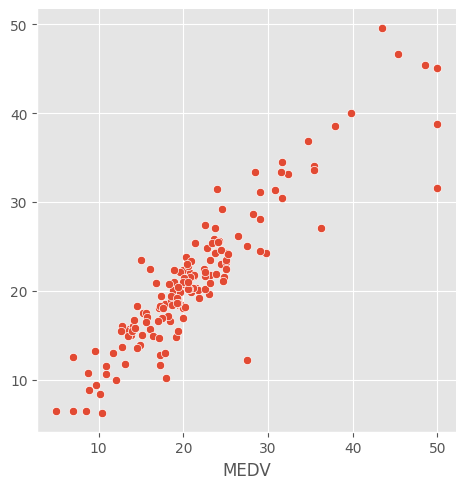

In [ ]:
sns.relplot(x = y_test, y = y_pred)
plt.show()

Quanto melhor for o modelo, mais parecido com uma diagonal devera estar

# Discretização

É basicamente converter as variaveis continuar em intervalos de valores, fazendo com que sejam categoricas

Desvantagens:
- esse metodo pode trazer pontos negativos em relação a perda de informação, pois estariamos tratando todos os valores que estiverem dentro de um intervalo X igualmente, sendo que muitas vezes essa diferenciação influencia no modelo final

Vantagens:
- A utilizade dela é devido a otimização do desempenho, tendo assim um processamento mais rapido, uma vez que ao inves de interpretar entre varios valores continuos, iremos analisar entre algumas poucas categorias
- Ganho de explicabilidade, uma vez que eh mais facil explicar alguns comportamentos usando intervalos, ao inves de mostrar cada valor
- Diminuir impactos de outliers **importante**
- apesar de nao ser tao comum, pode melhorar a prediçaõ de arvores de decisçao e naive bayes

No geral, creio que seja mais util para fazer Analise exploratoria do que para modelagem, mas pode ser util testar em algumas modelagens e analisar o comportamento

In [ ]:
houses.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


- É interessante tentar deixar a mesma quantidade de pessoas em cada grupo
- podemos usar arvore de decisão para tentar achar registros que estao proximos uns dos outros


In [ ]:
!pip install feature_engine

In [ ]:
from feature_engine.discretisation import EqualWidthDiscretiser, EqualFrequencyDiscretiser, DecisionTreeDiscretiser

Temos que treinar com TRAIN e aplicar no TEST

## Equal Discretiser

In [ ]:
ewd = EqualWidthDiscretiser()
ewd.fit(houses[['AGE']]) # Treinamos ele para entender como separar em categorias(teriamos que fazer priemeiro no X_train e depois X_Test)

EqualWidthDiscretiser()

In [ ]:
houses['AGE_EWD'] = ewd.transform(houses[['AGE']])
houses.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,AGE_EWD
0,0.00632,18.0,2.31,No,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0,6
1,0.02731,0.0,7.07,No,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6,7
2,0.02729,0.0,7.07,No,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7,5
3,0.03237,0.0,2.18,No,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4,4
4,0.06905,0.0,2.18,No,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2,5


In [ ]:
houses.groupby('AGE_EWD').agg({
        'AGE': ['mean', 'min', 'max', 'size']
    })

AGE                  
              mean   min    max size
AGE_EWD                             
0         7.442857   2.9   10.0   14
1        18.587097  13.0   22.3   31
2        28.675862  22.9   32.0   29
3        36.326190  32.1   41.5   42
4        45.978125  41.9   51.0   32
5        55.852632  51.8   61.1   38
6        66.317949  61.4   70.6   39
7        75.857143  71.0   80.3   42
8        85.795775  80.8   90.0   71
9        96.450000  90.3  100.0  168

Importante observar que esse metodo nao deixa a mesma quantidade de registros em cada grupo

## Equal Frequency Discretiser

In [ ]:
efd = EqualFrequencyDiscretiser()
efd.fit(houses[['AGE']]) # Treinamos ele para entender como separar em categorias(teriamos que fazer priemeiro no X_train e depois X_Test)
houses['AGE_EFD'] = efd.transform(houses[['AGE']])

houses.groupby('AGE_EFD').agg({
        'AGE': ['mean', 'min', 'max', 'size']
    })

AGE                  
              mean   min    max size
AGE_EFD                             
0        16.213725   2.9   26.3   51
1        32.443137  27.6   37.8   51
2        44.716000  38.1   52.3   50
3        58.652941  52.5   65.4   51
4        71.800000  66.1   77.3   50
5        82.254902  77.7   85.9   51
6        89.241176  86.1   91.8   51
7        93.982000  91.9   95.6   50
8        97.354717  95.7   98.8   53
9        99.897917  98.9  100.0   48

Não da pra dividir exatamente igual, mas ele tentou aproximas bastante a quantidade de registros por grupo

## Decision Tree Discretiser

In [ ]:
tree = DecisionTreeDiscretiser()
tree.fit(houses[['AGE']], houses[['MEDV']]) # Treinamos ele para entender como separar em categorias(teriamos que fazer priemeiro no X_train e depois X_Test)
houses['AGE_TREE'] = tree.transform(houses[['AGE']])

houses.groupby('AGE_TREE').agg({
        'AGE': ['mean', 'min', 'max', 'size']
    })

AGE                  
                mean   min    max size
AGE_TREE                              
17.483673  97.182993  92.4  100.0  147
21.681579  85.337719  76.5   92.2  114
24.730345  57.090345  37.3   76.0  145
27.739000  24.064000   2.9   37.2  100